## Analysing Monthly View Counts for Dinosaur Wikipedia Articles

We perform an analysis on how the number of views of different dinosaur wiki articles changed over July 2015 to September 2022. We aim to visualize how the access methods (mobile or desktop) lend to the number of views, the changes in views of top viewed articles of all time, and the changes in views of articles with minimum and maximum average view counts using mobile and desktop

In [1]:
import json, time, urllib.parse

In [2]:
import requests

In [3]:
import xlwings as xw

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

We collect the data using the list of dinosaur articles available at https://docs.google.com/spreadsheets/d/1zfBNKsuWOFVFTOGK8qnTr2DmHkYK4mAACBKk1sHLt_k/edit#gid=1345871712
<br> We take the names of articles and store them in **"article_list"**. That will serve as the key "article_name" in our API call.

In [6]:
wb = xw.Book('dinosaur_genera.cleaned.xlsx')
sht = wb.sheets('dinosaur_genera.cleaned')
article_list = sht.range('A2:A1424').value

The API invoked to get these views metrics is the Pageviews API. We pass the start and the end date, the article name, and the method of access to the API along with other constants such as granularity (which is monthly), user, project. We further add latency to the API calls because we do not want to exceed 100 requests per second to a publicly hosted API (find documentation here: [API Documentation](https://wikitech.wikimedia.org/wiki/Analytics/AQS/Pageviews), terms and conditions here: [Terms and Conditions for API use](https://www.mediawiki.org/wiki/REST_API#Terms_and_conditions) )

In [7]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include a "unique ID" that will allow them to
# contact you if something happens - such as - your code exceeding request limits - or some other error happens
REQUEST_HEADERS = {
    'User-Agent': '<anushka8@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2022',
}

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2022093000"    # this is likely the wrong end date
}

In [8]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(access_method,
                                  article_title = None,
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):
    # Make sure we have an article title
    if not article_title: return None
    
    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = article_title.replace(' ','_')
    article_title_encoded = article_title_encoded.replace('”','')
    article_title_encoded = article_title_encoded.replace('“','')
    request_template['article'] = article_title_encoded
    request_template['access'] = access_method
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
        
    except Exception as e:
        print(e)
        json_response = None
    return json_response

We proceed to create JSON files for desktop and mobile access views. For this, we invoke the API using the function created above, pass the access method as "desktop", and run a loop over all the dinosaur names to get the view counts for all the articles. We then remove the field "access" as required to avoid confusion for mobile access (sum of web and app), and keep appending the response to a blank list - result_dino_desktop

In [9]:
result_dino_desktop = list()
for article_name in article_list:
    views = request_pageviews_per_article('desktop', article_name)['items']
    for view in views:
        if 'access' in view:     
            del view['access']
    result_dino_desktop.append(views)

We save the list created as a JSON file using json.dump function in a file named - 'dino_monthly_desktop_201507-202209.json'


In [12]:
with open('dino_monthly_desktop_201507-202209.json', 'w') as output_file:
    json.dump(result_dino_desktop, output_file)

The process is repeated for mobile access. Here, we sum the view counts for mobile-app and mobile-web and follow the similar process as followed for desktop.

In [10]:
result_dino_mobile = list()
for article_name in article_list:
    views_mobile_web = request_pageviews_per_article("mobile-web", article_name)['items']
    views_mobile_app = request_pageviews_per_article("mobile-app", article_name)['items']
    
    for view_mobile_web, view_mobile_app in zip(views_mobile_web, views_mobile_app):
        #print(view_mobile_web)
        #print(view_mobile_app)
        if(view_mobile_web['timestamp']==view_mobile_app['timestamp']):
            view_mobile_web['views'] = view_mobile_web['views']+view_mobile_app['views']
        if 'access' in view_mobile_web:     
            del view_mobile_web['access']
            #print(view_mobile_web)
        result_dino_mobile.append(view_mobile_web)   

In [13]:
with open('dino_monthly_mobile_201507-20220.json', 'w') as output_file:
    json.dump(result_dino_mobile, output_file)

We finally create a cumulative view count JSON which has the total views for mobile and desktop and save it 

In [16]:
result_dino_all = list()
for article_name in article_list:
    views = request_pageviews_per_article('all-access', article_name)['items']
    for view in views:
        if 'access' in view:     
            del view['access']
    result_dino_all.append(views)

In [17]:
with open('dino_monthly_cumulative_201507-20220.json', 'w') as output_file:
    json.dump(result_dino_all, output_file)

In [14]:
# Function to generate data required for visualization
def sortFunc(e):
  return e["views"]

from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

We modify the mobile data to get it into the same format as desktop data. We will be then generating insights from this data by performing certain calculations on it which will help us create final visualizations.

In [15]:
#Creating mobile data in desired format
temp_dict_for_mobile = {}
for i in result_dino_mobile:
    if i["article"] in temp_dict_for_mobile:
        temp_dict_for_mobile[i["article"]].append(i)
    else:
        temp_dict_for_mobile[i["article"]] = []
        temp_dict_for_mobile[i["article"]].append(i)
        
list_result_dino_mobile = []
for i in temp_dict_for_mobile:
    list_result_dino_mobile.append(temp_dict_for_mobile[i])
    
#print(list_result_dino_mobile)

To generate the data to retrieve top 10 articles with maximum views, we reverse sort the data based on "views", extract 10 articles, get the article-name for these articles. This helps us in identifying the "popular dinosaurs". From here, we create a dictionary with the dinosaur name as the key and the list of data which we received from the API (that contains views and timestamp) as the value.

In [16]:
# generates the sorted order of timeseries for desktop
desktop_article_series_data_dict = {}
sorted_desktop_article_series_data_dict = {}
desktop_article_peak_dict = {}
for i in result_dino_desktop:
  j = i
  i.sort(reverse=True, key=sortFunc)
  desktop_article_series_data_dict[j[0]["article"]] = j
  desktop_article_peak_dict[j[0]["article"]] = i[0]["views"] # adding peak to the dictionary dino: peak views
  #print(desktop_article_peak_dict)
  #print(desktop_article_series_data_dict)
  #break
sorted_desktop_article_peak_dict = take(10, reversed(list(sorted(desktop_article_peak_dict.items(), key=lambda kv:
                 (kv[1], kv[0]))))) # top 10 views dinos
print(sorted_desktop_article_peak_dict) 

for i in sorted_desktop_article_peak_dict:
  sorted_desktop_article_series_data_dict[i[0]] = desktop_article_series_data_dict[i[0]] # making a dictionary of top 10 dinos with dinos: all data

#print(sorted_desktop_article_series_data_dict) 
#print(len(sorted_desktop_article_series_data_dict))

[('Achelousaurus', 205150), ('Velociraptor', 135741), ('Tyrannosaurus', 107257), ('Halszkaraptor', 103251), ('Giganotosaurus', 62340), ('Spinosaurus', 61029), ('Lythronax', 57701), ('Nigersaurus', 57192), ('Borealopelta', 53831), ('Dilophosaurus', 53278)]


Same process is followed for data which has access mode as "mobile".

In [18]:
# generates the sorted order of timeseries for mobile
#print(result_dino_desktop)
mobile_article_series_data_dict = {}
sorted_mobile_article_series_data_dict = {}
mobile_article_peak_dict = {}
for i in list_result_dino_mobile:
  j = i
  i.sort(reverse=True, key=sortFunc)
  mobile_article_series_data_dict[j[0]["article"]] = j
  mobile_article_peak_dict[j[0]["article"]] = i[0]["views"] # adding peak to the dictionary dino: peak views
  #print(desktop_article_peak_dict)
  #print(desktop_article_series_data_dict)
  #break
sorted_mobile_article_peak_dict = take(10, reversed(list(sorted(mobile_article_peak_dict.items(), key=lambda kv:
                 (kv[1], kv[0]))))) # top 10 views dinos
print(sorted_mobile_article_peak_dict) 

for i in sorted_mobile_article_peak_dict:
  sorted_mobile_article_series_data_dict[i[0]] = mobile_article_series_data_dict[i[0]] # making a dictionary of top 10 dinos with dinos: all data

#print(sorted_mobile_article_series_data_dict) 
#print(len(sorted_mobile_article_series_data_dict))

[('Nigersaurus', 235977), ('Deinocheirus', 234704), ('Giganotosaurus', 165007), ('Therizinosaurus', 155431), ('Velociraptor', 142284), ('Achelousaurus', 140592), ('Tyrannosaurus', 139326), ('Borealopelta', 117282), ('Dilophosaurus', 78537), ('Argentinosaurus', 78437)]


To create the visualization, we create a dataframe which contains the timestamp as index, and the view counts for the top 10 dinosaurs. We further sort the dataframe on "timestamp" so as to create a time-series plot.

In [34]:
# Creating a data frame for visualization 2 for desktop 

df_final2_desk = pd.DataFrame(columns=['timestamp'])
for ele in sorted_desktop_article_series_data_dict:
    df = pd.DataFrame(columns=['timestamp',ele+"_Desktop"])
    for element in sorted_desktop_article_series_data_dict[ele]:
        df2= pd.DataFrame({'timestamp': element['timestamp'], ele+"_Desktop": element['views']}, index=[1])
        df = pd.concat([df, df2])
    df_final2_desk= pd.merge(df_final2_desk, df, on='timestamp', how='outer').fillna(0)
df_final2_desk['timestamp'] = df_final2_desk['timestamp'].astype(int)
df_final2_desk=df_final2_desk.sort_values('timestamp')

In [35]:
# Creating a data frame for visualization 2 for mobile 

df_final2_mob = pd.DataFrame(columns=['timestamp'])
for ele in sorted_mobile_article_series_data_dict:
    df = pd.DataFrame(columns=['timestamp',ele+"_Mobile"])
    for element in sorted_mobile_article_series_data_dict[ele]:
        df2= pd.DataFrame({'timestamp': element['timestamp'], ele+"_Mobile": element['views']}, index=[1])
        df = pd.concat([df, df2])
    df_final2_mob= pd.merge(df_final2_mob, df, on='timestamp', how='outer').fillna(0)
df_final2_mob['timestamp'] = df_final2_mob['timestamp'].astype(int)
df_final2_mob=df_final2_mob.sort_values('timestamp')

In [36]:
df_final2_desk.set_index('timestamp')
df_final2_mob.set_index('timestamp')

,Nigersaurus_Mobile,Deinocheirus_Mobile,Giganotosaurus_Mobile,Therizinosaurus_Mobile,Velociraptor_Mobile,Achelousaurus_Mobile,Tyrannosaurus_Mobile,Borealopelta_Mobile,Dilophosaurus_Mobile,Argentinosaurus_Mobile
timestamp,,,,,,,,,,
2015070100,640,1609,28695,4743,142284,464,113592,0,29889,11373
2015080100,478,1042,15427,3598,53874,321,61089,0,16315,8070
2015090100,404,856,11192,3303,36498,301,47233,0,11006,7626
2015100100,481,1004,16773,4030,63287,322,63541,0,14367,7104
2015110100,498,997,15951,3343,51807,325,56612,0,11173,7274
...,...,...,...,...,...,...,...,...,...,...
2022050100,11879,13039,27443,14672,45282,5340,68130,2202,15843,10425
2022060100,7838,10698,165007,155431,75803,11576,116521,2157,78537,12601
2022070100,7591,5755,88920,70089,46600,24269,88247,2185,38969,13176


In [37]:
df_final2_merge= pd.merge(df_final2_mob, df_final2_desk, on='timestamp', how='outer').fillna(0)

We transform the "timestamp" field to convert it into a datetime field. This helps in creating cleaner and more meaningful visualizations.

In [102]:
df_final2_merge_test = df_final2_merge
df_final2_merge_test['timestamp'] = df_final2_merge_test['timestamp'].apply(lambda x: str(x)[0:8])
df_final2_merge_test['timestamp'] = df_final2_merge_test['timestamp'].astype(int)
df_final2_merge_test['timestamp'] = pd.to_datetime(df_final2_merge_test['timestamp'], format='%Y%m%d').dt.strftime('%m/%d/%Y')


We create a visualization that shows the view count trend of the **top 10 articles with highest all time views** with access method desktop and mobile. The popular dinosaurs along with their mode of access are as shown in the legend.

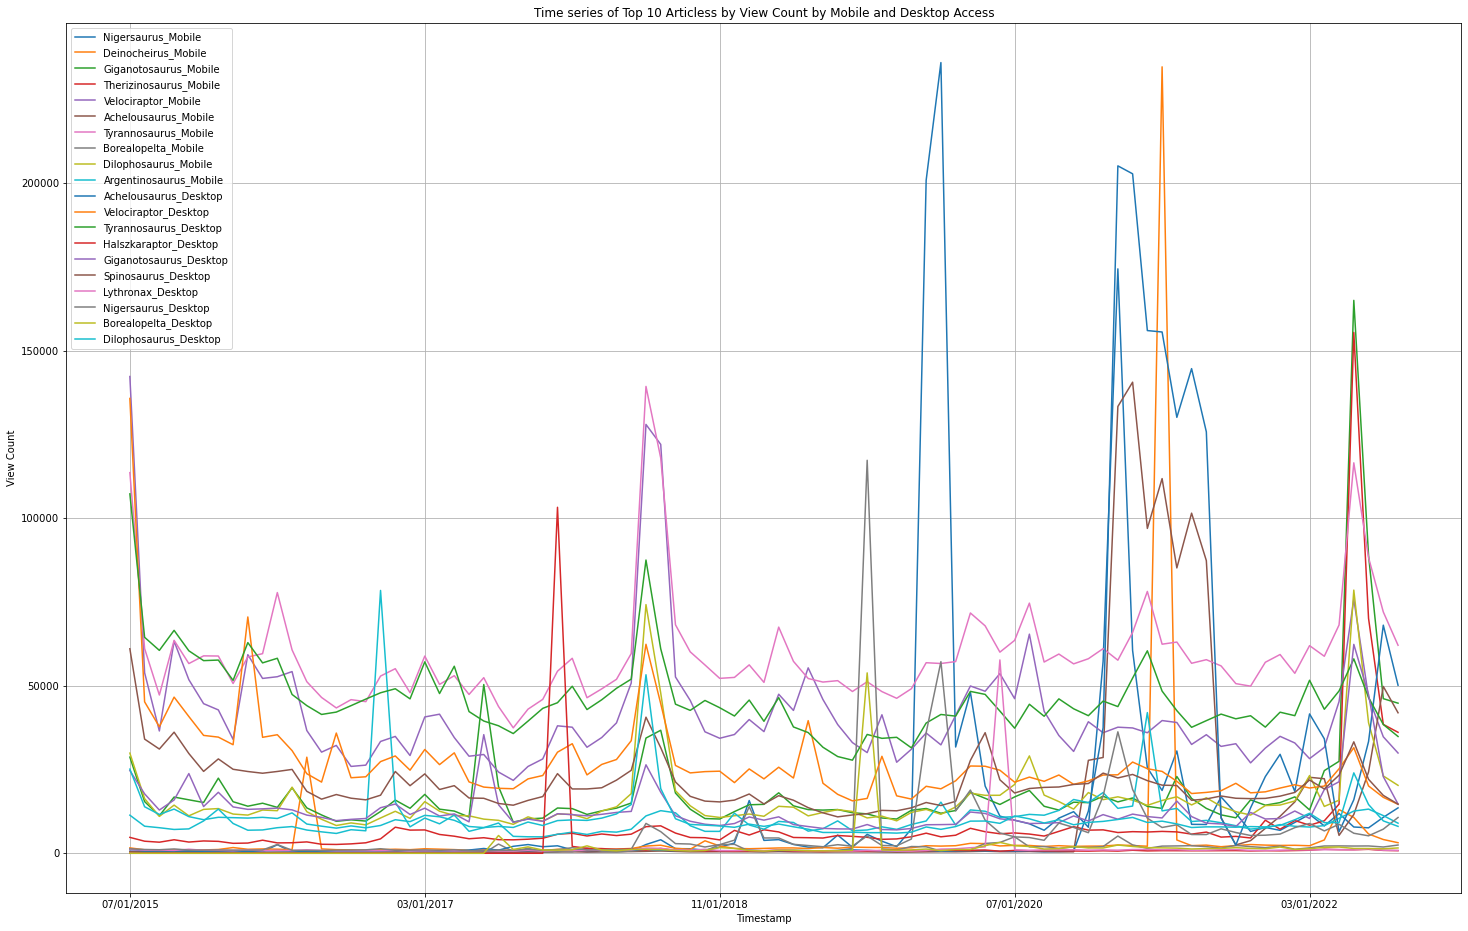

In [105]:
df_plot_2 = df_final2_merge_test.plot('timestamp', figsize=(25,16), title='Time series of Top 10 Articles by View Count by Mobile and Desktop Access')
df_plot_2.set_ylabel("View Count")
df_plot_2.set_xlabel("Timestamp")
df_plot_2.legend(loc = 'upper left')
df_plot_2.grid()

In [106]:
fig2 = df_plot_2.get_figure()
fig2.savefig("viz2.png", bbox_inches='tight')

To generate the articles with **fewest months of data**, we simply check the length of the list returned which contains the object with timestamp and view counts for each dinosaur. We then select the first 10 dinosaurs from this sorted result and create a dictionary with dinosaur name as key and their list of results as value, as done for the previous visualization.

In [27]:
# generates the 10 minimum desktop article count - part 3
desktop_article_series_data_dict = {}
desktop_article_data_count_dict = {}
minimum_desktop_article_series_data_dict = {}
for i in result_dino_desktop:
  j = i
  desktop_article_series_data_dict[j[0]["article"]] = j # dinos: all data
  desktop_article_data_count_dict[j[0]["article"]] = len(j) # dino : number of month of data
  #print(desktop_article_peak_dict)
  #print(desktop_article_series_data_dict)
  #break
sorted_desktop_article_data_count_dict = take(10, list(sorted(desktop_article_data_count_dict.items(), key=lambda kv:
                 (kv[1], kv[0])))) # top 10 fewest data dinos
print(sorted_desktop_article_data_count_dict) 

for i in sorted_desktop_article_data_count_dict:
  minimum_desktop_article_series_data_dict[i[0]] = desktop_article_series_data_dict[i[0]] # dino: all data for few 10 dinos

#print(minimum_desktop_article_series_data_dict) 

[('Elemgasem', 1), ('Tuebingosaurus', 1), ('Bisticeratops', 2), ('Jakapil', 2), ('Mbiresaurus', 2), ('Perijasaurus', 2), ('Iyuku', 3), ('Paralitherizinosaurus', 5), ('Bashanosaurus', 7), ('Dzharaonyx', 7)]


In [28]:
df_final3_desk = pd.DataFrame(columns=['timestamp'])
for ele in minimum_desktop_article_series_data_dict:
    df = pd.DataFrame(columns=['timestamp',ele+"_Desktop"])
    for element in minimum_desktop_article_series_data_dict[ele]:
        df2= pd.DataFrame({'timestamp': element['timestamp'], ele+"_Desktop": element['views']}, index=[1])
        df = pd.concat([df, df2])

    df_final3_desk= pd.merge(df_final3_desk, df, on='timestamp', how='outer').fillna(0)
df_final3_desk['timestamp'] = df_final3_desk['timestamp'].astype(int)
df_final3_desk=df_final3_desk.sort_values('timestamp')

In [29]:
df_final3_desk.set_index('timestamp')

,Elemgasem_Desktop,Tuebingosaurus_Desktop,Bisticeratops_Desktop,Jakapil_Desktop,Mbiresaurus_Desktop,Perijasaurus_Desktop,Iyuku_Desktop,Paralitherizinosaurus_Desktop,Bashanosaurus_Desktop,Dzharaonyx_Desktop
timestamp,,,,,,,,,,
2022030100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2351,1061
2022040100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,438,282
2022050100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1875.0,385,315
2022060100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.0,379,280
2022070100,0.0,0.0,0.0,0.0,0.0,0.0,1110.0,591.0,307,206
2022080100,0.0,0.0,1825.0,8745.0,265.0,1331.0,486.0,438.0,364,215
2022090100,1345.0,1423.0,824.0,1897.0,2632.0,330.0,279.0,400.0,268,206


In [30]:
# generates the 10 minimum mobile article count - part 3
mobile_article_series_data_dict = {}
mobile_article_data_count_dict = {}
minimum_mobile_article_series_data_dict = {}
for i in list_result_dino_mobile:
  j = i
  mobile_article_series_data_dict[j[0]["article"]] = j # dinos: all data
  mobile_article_data_count_dict[j[0]["article"]] = len(j) # dino : number of month of data

sorted_mobile_article_data_count_dict = take(10, list(sorted(mobile_article_data_count_dict.items(), key=lambda kv:
                 (kv[1], kv[0])))) # top 10 fewest data dinos
print(sorted_mobile_article_data_count_dict) 

for i in sorted_mobile_article_data_count_dict:
  minimum_mobile_article_series_data_dict[i[0]] = mobile_article_series_data_dict[i[0]] # dino: all data for few 10 dinos

#print(minimum_mobile_article_series_data_dict) 

[('Elemgasem', 1), ('Tuebingosaurus', 1), ('Bisticeratops', 2), ('Jakapil', 2), ('Mbiresaurus', 2), ('Perijasaurus', 2), ('Iyuku', 3), ('Paralitherizinosaurus', 5), ('Bashanosaurus', 7), ('Dzharaonyx', 7)]


In [31]:
df_final3_mob = pd.DataFrame(columns=['timestamp'])
for ele in minimum_desktop_article_series_data_dict:
    df = pd.DataFrame(columns=['timestamp',ele+"_Mobile"])
    for element in minimum_desktop_article_series_data_dict[ele]:
        df2= pd.DataFrame({'timestamp': element['timestamp'], ele+"_Mobile": element['views']}, index=[1])
        df = pd.concat([df, df2])
    if ele == 'Abdarainurus':
        df.to_csv('out2.csv')
    df_final3_mob= pd.merge(df_final3_mob, df, on='timestamp', how='outer').fillna(0)
df_final3_mob['timestamp'] = df_final3_mob['timestamp'].astype(int)
df_final3_mob=df_final3_mob.sort_values('timestamp')
df_final3_mob.set_index('timestamp')


,Elemgasem_Mobile,Tuebingosaurus_Mobile,Bisticeratops_Mobile,Jakapil_Mobile,Mbiresaurus_Mobile,Perijasaurus_Mobile,Iyuku_Mobile,Paralitherizinosaurus_Mobile,Bashanosaurus_Mobile,Dzharaonyx_Mobile
timestamp,,,,,,,,,,
2022030100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2351,1061
2022040100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,438,282
2022050100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1875.0,385,315
2022060100,0.0,0.0,0.0,0.0,0.0,0.0,0.0,806.0,379,280
2022070100,0.0,0.0,0.0,0.0,0.0,0.0,1110.0,591.0,307,206
2022080100,0.0,0.0,1825.0,8745.0,265.0,1331.0,486.0,438.0,364,215
2022090100,1345.0,1423.0,824.0,1897.0,2632.0,330.0,279.0,400.0,268,206


In [32]:
df_final3_merge= pd.merge(df_final3_mob, df_final3_desk, on='timestamp', how='outer').fillna(0)

In [99]:
df_final3_merge_test = df_final3_merge
df_final3_merge_test['timestamp'] = df_final3_merge_test['timestamp'].apply(lambda x: str(x)[0:8])
df_final3_merge_test['timestamp'] = df_final3_merge_test['timestamp'].astype(int)
df_final3_merge_test['timestamp'] = pd.to_datetime(df_final3_merge_test['timestamp'], format='%Y%m%d').dt.strftime('%m/%d/%Y')


We get the final dataframe with results from desktop and mobile combined. In the visualization, we can clearly see the dinosaurs with fewest months of data. We see the curve is largely flat with a few peaks.

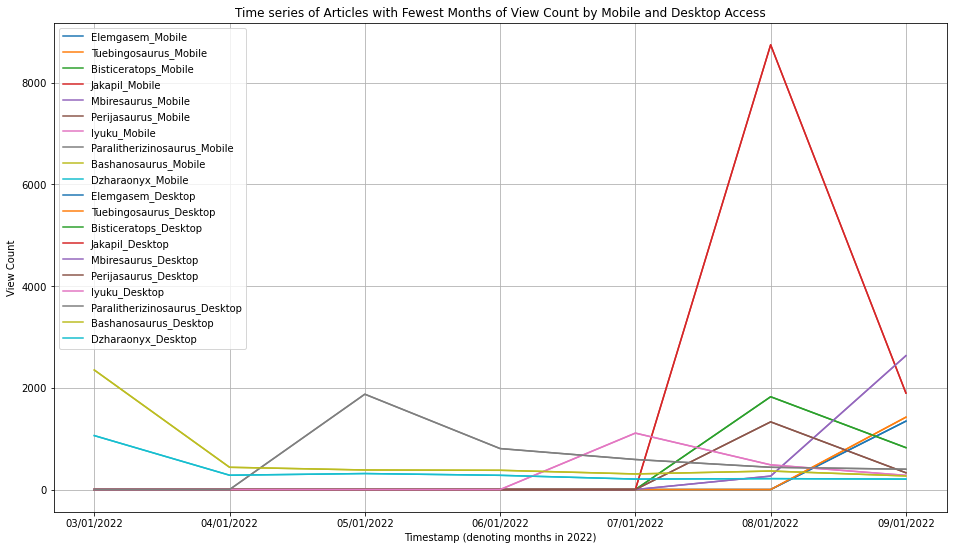

In [107]:
df_plot_3 = df_final3_merge_test.plot('timestamp', figsize=(16,9), title='Time series of Articles with Fewest Months of View Count by Mobile and Desktop Access')
df_plot_3.set_ylabel("View Count")
df_plot_3.set_xlabel("Timestamp (denoting months in 2022)")
df_plot_3.grid()

In [101]:
fig3 = df_plot_3.get_figure()
fig3.savefig("viz3.png", bbox_inches='tight')

For getting the **minimum and maximum average of views for desktop and mobile**, we simply loop over the articles and get the average for each dinosaur. We then select the ones with minimum and maximum average and once again, create a dictionary with dinosaur name as key and the list of objects which contain timestamp and view counts as values. 

In [40]:
# generates the minimum maximum avg desktop articles - part 1

desktop_article_series_data_dict = {}
desktop_minimum_maximum_avg_dict = {}
avgGraphs = {}
minimum_desktop_article_series_data_dict = {}
for i in result_dino_desktop:
  desktop_article_series_data_dict[i[0]["article"]] = i
  sum = 0
  for j in i: 
    sum = sum + j["views"]
  avg = sum/len(i)
  desktop_minimum_maximum_avg_dict[i[0]["article"]] = avg
  #print(desktop_article_peak_dict)
  #print(desktop_article_series_data_dict)
  #break
sorted_desktop_minimum_avg_dict = take(1, list(sorted(desktop_minimum_maximum_avg_dict.items(), key=lambda kv:
                 (kv[1], kv[0])))) # takig minimum
sorted_desktop_maximum_avg_dict = take(1, reversed(list(sorted(desktop_minimum_maximum_avg_dict.items(), key=lambda kv:
                 (kv[1], kv[0]))))) # taking maximum


avgGraphs[sorted_desktop_maximum_avg_dict[0][0]] = desktop_article_series_data_dict[sorted_desktop_maximum_avg_dict[0][0]]
avgGraphs[sorted_desktop_minimum_avg_dict[0][0]] = desktop_article_series_data_dict[sorted_desktop_minimum_avg_dict[0][0]]


print(sorted_desktop_minimum_avg_dict)
print(sorted_desktop_maximum_avg_dict)
#print(avgGraphs) 

[('Honghesaurus', 16.96551724137931)]
[('Tyrannosaurus', 46406.0)]


We once again create a dataframe to get the timestamp as index and the view counts for both the dinosaurs for each of them (with the dinosaurs as columns). This makes the comparison easy and intuitive and helps in easy visualizatio.  

In [41]:
df_avg_desk = pd.DataFrame(columns=['timestamp'])
for ele in avgGraphs:
    df = pd.DataFrame(columns=['timestamp',ele+"_Desktop"])
    for element in avgGraphs[ele]:
        df2= pd.DataFrame({'timestamp': element['timestamp'], ele+"_Desktop": element['views']}, index=[1])
        df = pd.concat([df, df2])
    df_avg_desk= pd.merge(df_avg_desk, df, on='timestamp', how='outer').fillna(0)
df_avg_desk['timestamp'] = df_avg_desk['timestamp'].astype(int)
df_avg_desk=df_avg_desk.sort_values('timestamp')
df_avg_desk.set_index('timestamp')

,Tyrannosaurus_Desktop,Honghesaurus_Desktop
timestamp,,
2015070100,107257,23
2015080100,64452,13
2015090100,60550,27
2015100100,66527,16
2015110100,60426,10
...,...,...
2022050100,48438,349
2022060100,58017,82
2022070100,46505,44


The process that was followed for desktop is repeated for mobile access view counts as well. We will then merge the two dataframes to get a single dataframe to build visualizations from.

In [42]:
# generates the minimum maximum avg mobile articles - part 1

mobile_article_series_data_dict = {}
mobile_minimum_maximum_avg_dict = {}
avgGraphs1 = {}
minimum_mobile_article_series_data_dict = {}
for i in list_result_dino_mobile:
  mobile_article_series_data_dict[i[0]["article"]] = i
  sum = 0
  for j in i: 
    sum = sum + j["views"]
  avg = sum/len(i)
  mobile_minimum_maximum_avg_dict[i[0]["article"]] = avg
  #print(desktop_article_peak_dict)
  #print(desktop_article_series_data_dict)
  #break
sorted_mobile_minimum_avg_dict = take(1, list(sorted(mobile_minimum_maximum_avg_dict.items(), key=lambda kv:
                 (kv[1], kv[0])))) # takig minimum
sorted_mobile_maximum_avg_dict = take(1, reversed(list(sorted(mobile_minimum_maximum_avg_dict.items(), key=lambda kv:
                 (kv[1], kv[0]))))) # taking maximum


avgGraphs1[sorted_mobile_maximum_avg_dict[0][0]] = mobile_article_series_data_dict[sorted_mobile_maximum_avg_dict[0][0]]
avgGraphs1[sorted_mobile_minimum_avg_dict[0][0]] = mobile_article_series_data_dict[sorted_mobile_minimum_avg_dict[0][0]]


print(sorted_mobile_minimum_avg_dict)
print(sorted_mobile_maximum_avg_dict)
#print(avgGraphs1) 

[('Honghesaurus', 5.885057471264368)]
[('Tyrannosaurus', 59537.70114942529)]


In [43]:
df_avg_mob = pd.DataFrame(columns=['timestamp'])
for ele in avgGraphs1:
    df = pd.DataFrame(columns=['timestamp',ele+"_Mobile"])
    for element in avgGraphs1[ele]:
        df2= pd.DataFrame({'timestamp': element['timestamp'], ele+"_Mobile": element['views']}, index=[1])
        df = pd.concat([df, df2])
    df_avg_mob= pd.merge(df_avg_mob, df, on='timestamp', how='outer').fillna(0)
df_avg_mob['timestamp'] = df_avg_mob['timestamp'].astype(int)
df_avg_mob=df_avg_mob.sort_values('timestamp')
df_avg_mob.set_index('timestamp')

,Tyrannosaurus_Mobile,Honghesaurus_Mobile
timestamp,,
2015070100,113592,6
2015080100,61089,5
2015090100,47233,2
2015100100,63541,1
2015110100,56612,3
...,...,...
2022050100,68130,146
2022060100,116521,31
2022070100,88247,22


In [44]:
df_avg_merge= pd.merge(df_avg_mob, df_avg_desk, on='timestamp', how='outer').fillna(0)

In [93]:
df_avg_merge_test = df_avg_merge

In [95]:

df_avg_merge_test['timestamp'] = df_avg_merge_test['timestamp'].apply(lambda x: str(x)[0:8])
df_avg_merge_test['timestamp'] = df_avg_merge_test['timestamp'].astype(int)
df_avg_merge_test['timestamp'] = pd.to_datetime(df_avg_merge_test['timestamp'], format='%Y%m%d').dt.strftime('%m/%d/%Y')

The visualization is very similar for the minimum average counts - almost flat. The maximum average for mobile and desktop also follows a similar trend over the years. The dino with minimum average view count is **Honghesaurus**, the one with maximum average view count is **Tyrannosaurus**.

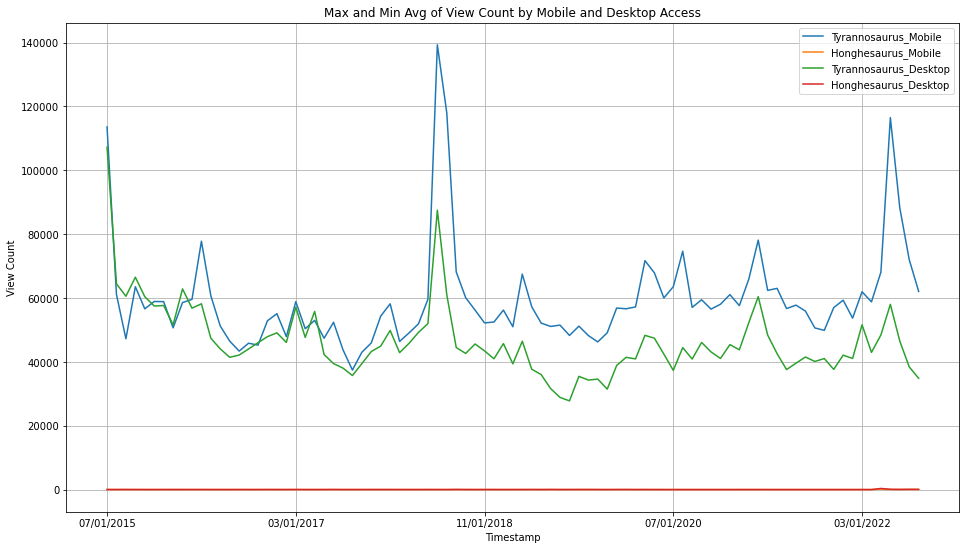

In [97]:
df_plot_1 = df_avg_merge_test.plot('timestamp', figsize=(16,9), title='Max and Min Avg of View Count by Mobile and Desktop Access')
df_plot_1.set_ylabel("View Count")
df_plot_1.set_xlabel("Timestamp")
df_plot_1.grid()


In [98]:
fig = df_plot_1.get_figure()
fig.savefig("viz1.png", bbox_inches='tight')